In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
df = pd.read_csv("LeagueofLegends.csv")

In [3]:
X = df.select_dtypes(include=['float64', 'int64']).drop(columns=['bResult', 'rResult'])  # Features
y = df['bResult']  # Target

In [4]:
# Splitting the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
# Converting to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

In [7]:
print(X_train_tensor.shape, X_test_tensor.shape, y_train_tensor.shape, y_test_tensor.shape)

torch.Size([6096, 2]) torch.Size([1524, 2]) torch.Size([6096]) torch.Size([1524])


In [8]:
# Define the logistic regression model class

class LogRegModel(nn.Module):
    def __init__(self, input_dim):
        super(LogRegModel, self).__init__()
        # Linear layer with a single output
        self.linear = nn.Linear(input_dim, 1)
    
    def forward(self, x):
        # Apply the linear layer followed by a sigmoid activation for binary classification
        return torch.sigmoid(self.linear(x))

In [9]:
input_dim = X_train_tensor.shape[1]  # Number of features

In [11]:
model = LogRegModel(input_dim)
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.SGD(model.parameters(), lr=0.01) 

In [12]:
print(model)

LogRegModel(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)


In [13]:
num_epochs = 100
learning_rate = 0.01

In [14]:
# Training loop
for epoch in range(num_epochs):
 
    model.train()
    
    # Forward pass: compute predictions and loss
    outputs = model(X_train_tensor).squeeze()  # Squeeze to match target dimensions
    loss = criterion(outputs, y_train_tensor)
    
   
    optimizer.zero_grad()  # Clear gradients
    loss.backward()        # Backpropagation
    optimizer.step()       # Update model parameters

    # Print loss every 10 epochs for tracking
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [10/100], Loss: 0.7703
Epoch [20/100], Loss: 0.7666
Epoch [30/100], Loss: 0.7631
Epoch [40/100], Loss: 0.7598
Epoch [50/100], Loss: 0.7566
Epoch [60/100], Loss: 0.7535
Epoch [70/100], Loss: 0.7505
Epoch [80/100], Loss: 0.7477
Epoch [90/100], Loss: 0.7449
Epoch [100/100], Loss: 0.7423


In [15]:
def evaluate_model(model, X, y):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient computation
        predictions = model(X).squeeze() >= 0.5  # Predict class (1 if >=0.5, else 0)
        accuracy = (predictions == y).float().mean()  # Calculate accuracy
    return accuracy.item()

In [17]:
train_accuracy = evaluate_model(model, X_train_tensor, y_train_tensor)
test_accuracy = evaluate_model(model, X_test_tensor, y_test_tensor)

print(f'Training Accuracy: {train_accuracy * 100:.2f}%')
print(f'Testing Accuracy: {test_accuracy * 100:.2f}%')

Training Accuracy: 47.18%
Testing Accuracy: 46.33%


In [18]:
weight_decay = 0.01

In [19]:
model = LogRegModel(input_dim)
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)  # Adding weight_decay for L2 regularization


In [20]:
# Retrain the model with L2 regularization
for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train_tensor).squeeze()
    loss = criterion(outputs, y_train_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [10/100], Loss: 0.7245
Epoch [20/100], Loss: 0.7229
Epoch [30/100], Loss: 0.7213
Epoch [40/100], Loss: 0.7198
Epoch [50/100], Loss: 0.7184
Epoch [60/100], Loss: 0.7170
Epoch [70/100], Loss: 0.7157
Epoch [80/100], Loss: 0.7144
Epoch [90/100], Loss: 0.7132
Epoch [100/100], Loss: 0.7121


In [21]:
train_accuracy = evaluate_model(model, X_train_tensor, y_train_tensor)
test_accuracy = evaluate_model(model, X_test_tensor, y_test_tensor)

print(f'Training Accuracy (with L2 regularization): {train_accuracy * 100:.2f}%')
print(f'Testing Accuracy (with L2 regularization): {test_accuracy * 100:.2f}%')

Training Accuracy (with L2 regularization): 50.94%
Testing Accuracy (with L2 regularization): 51.77%


In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc


In [24]:
# Generate predictions on the test set
model.eval()
with torch.no_grad():
    y_test_pred_probs = model(X_test_tensor).squeeze()  # Get probabilities
    y_test_pred = (y_test_pred_probs >= 0.5).float()    # Convert probabilities to binary predictions


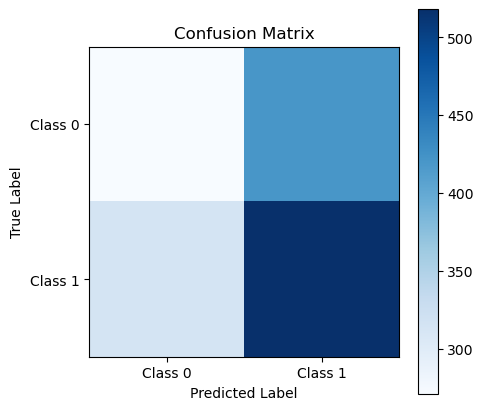

In [25]:
conf_matrix = confusion_matrix(y_test_tensor, y_test_pred)
plt.figure(figsize=(5, 5))
plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks([0, 1], ['Class 0', 'Class 1'])
plt.yticks([0, 1], ['Class 0', 'Class 1'])
plt.show()

In [26]:
print("Classification Report:")
print(classification_report(y_test_tensor, y_test_pred))

Classification Report:
              precision    recall  f1-score   support

         0.0       0.46      0.39      0.42       691
         1.0       0.55      0.62      0.58       833

    accuracy                           0.52      1524
   macro avg       0.51      0.51      0.50      1524
weighted avg       0.51      0.52      0.51      1524



In [27]:
# Plot the ROC curve and calculate the AUC
fpr, tpr, _ = roc_curve(y_test_tensor, y_test_pred_probs)
roc_auc = auc(fpr, tpr)

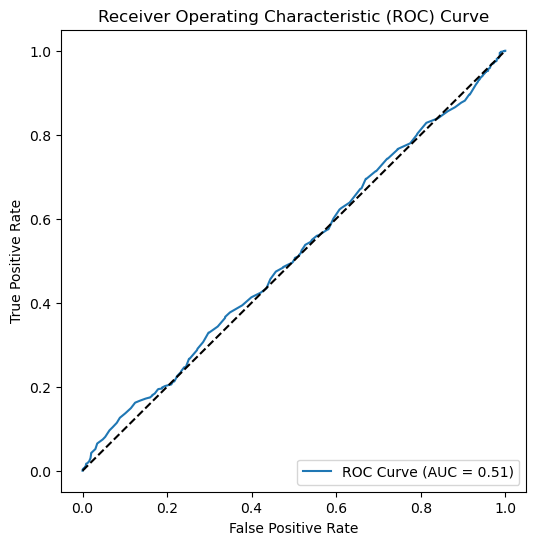

In [28]:
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [30]:
# Save the model's state dictionary
model_path = 'logistic_regression_model.pth'
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

# Load the model's state dictionary into a new model instance
loaded_model = LogRegModel(input_dim)
loaded_model.load_state_dict(torch.load(model_path))
loaded_model.eval()  # Set the loaded model to evaluation mode

# Evaluate the loaded model on the test set to ensure consistency
loaded_test_accuracy = evaluate_model(loaded_model, X_test_tensor, y_test_tensor)
print(f'Testing Accuracy of Loaded Model: {loaded_test_accuracy * 100:.2f}%')

Model saved to logistic_regression_model.pth
Testing Accuracy of Loaded Model: 51.77%


In [31]:
# List of learning rates to test
learning_rates = [0.001, 0.01, 0.05, 0.1, 0.2]
num_epochs = 50  # Number of epochs for each trial
best_accuracy = 0
best_lr = None

for lr in learning_rates:
    # Reinitialize the model and optimizer for each learning rate
    model = LogRegModel(input_dim)
    criterion = nn.BCELoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)

    # Train the model
    for epoch in range(num_epochs):
        model.train()
        outputs = model(X_train_tensor).squeeze()
        loss = criterion(outputs, y_train_tensor)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Evaluate the model on the test set
    test_accuracy = evaluate_model(model, X_test_tensor, y_test_tensor)
    print(f'Learning Rate: {lr}, Test Accuracy: {test_accuracy * 100:.2f}%')
    
    # Update best learning rate if current accuracy is higher
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        best_lr = lr

# Print the best learning rate and corresponding test accuracy
print(f'Best Learning Rate: {best_lr}, Test Accuracy: {best_accuracy * 100:.2f}%')

Learning Rate: 0.001, Test Accuracy: 52.82%
Learning Rate: 0.01, Test Accuracy: 53.74%
Learning Rate: 0.05, Test Accuracy: 52.49%
Learning Rate: 0.1, Test Accuracy: 50.07%
Learning Rate: 0.2, Test Accuracy: 54.59%
Best Learning Rate: 0.2, Test Accuracy: 54.59%


In [32]:
weights = model.linear.weight.detach().numpy().flatten()  # Convert tensor to numpy array and flatten

# Create a DataFrame with feature names and their corresponding weights
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': weights
})

In [33]:
# Sort the DataFrame by absolute importance values
feature_importance_df['Absolute Importance'] = feature_importance_df['Importance'].abs()
feature_importance_df = feature_importance_df.sort_values(by='Absolute Importance', ascending=False)


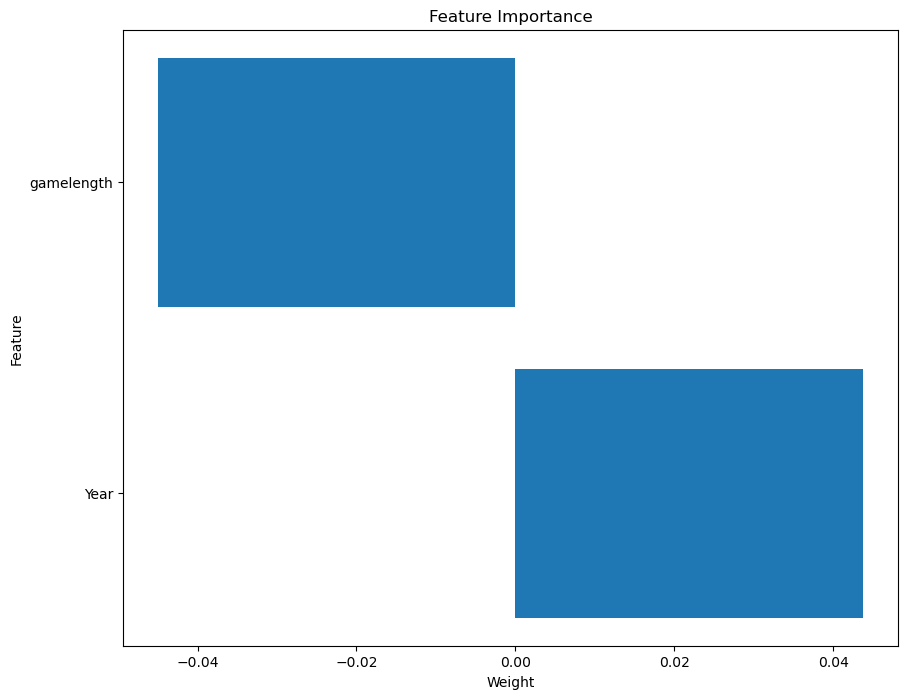

In [34]:
plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Weight')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()